# A study of Bitcoin transaction graph

# Importing needed modules and functions definitions

In [163]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import random as rand
import math

# for Notebook
%matplotlib inline

Define function for drawing with node colors depending on a given centrality measure, function for filter by time imported data

In [164]:
def filter_by_timestamp(G, timestamp_start, timestamp_end):
  for n in G:
    for m in G:
      edge_timestamp = G[n][m]["timestamp"]
      if edge_timestamp < timestamp_start or edge_timestamp > timestamp_end:
        G.remove_edge(n, m)
  return G

def directed_chung_lu(G, seed=None):
  G_degree_sequence = [d for n, d in G.degree()]
  CL = nx.expected_degree_graph(G_degree_sequence, seed=seed, selfloops=False)
  CL_directed = CL.to_directed()

  edge_list = list(CL_directed.edges())

  count = 0
  while(count < len(G.edges())):
    random_index = rand.randint(0, len(edge_list) - 1)
    CL_directed.remove_edge(edge_list[random_index][0], edge_list[random_index][1])
    edge_list.pop(random_index)
    count += 1

  return CL_directed

def single_zscore(value, expectancy, std_dev):
  return (value-expectancy)/std_dev

def compute_zscore_set(metric, rand_graph_metric):
  zscores = {}
  rand_graph_mean = np.mean(rand_graph_metric)
  rand_graph_std_dev = np.std(rand_graph_metric)

  for key,value in metric.items():
    zscores[key] = single_zscore(value, rand_graph_mean, rand_graph_std_dev)
  
  return zscores

def z_test(metric, rand_graph_metric):

  metric_mean = np.mean(np.array(list(metric.values())))
  metric_std_dev = np.std(np.array(list(metric.values())))

  rand_graph_mean = np.mean(np.array(list(rand_graph_metric.values())))
  rand_graph_std_dev = np.std(np.array(list(rand_graph_metric.values())))

  return (metric_mean - rand_graph_mean) / math.sqrt(metric_std_dev**2 + rand_graph_std_dev**2)
  
def compute_metrics(graph):

  metrics = {}
  
  metrics["deg_centrality"] = nx.degree_centrality(graph)
  metrics["close_centrality"] = nx.closeness_centrality(graph)
  metrics["betw_centrality"] = nx.betweenness_centrality(graph)
  metrics["local_clust"] = nx.clustering(graph)
  metrics["avg_clust"] = nx.average_clustering(graph)
  
  return metrics

def single_pvalue(feature_val, rand_graph_metric):
  t_stat, p_val = stats.ttest_1samp(rand_graph_metric, popmean=feature_val)

  return p_val

def compute_pvalue_set(metric, rand_graph_metric):
  pvalues = {}
  for key, value in metric.items():
    pvalues[key] = single_pvalue(value, rand_graph_metric)

  return pvalues

# Alpha and OTC datasets

Load the data & check of the number of nodes and edges.

In [165]:
df_alpha = pd.read_csv("soc-sign-bitcoinalpha.csv", header=None, names=["ID_from", "ID_to", "trust", "timestamp"], dtype={"ID_from":np.int32, "ID_to":np.int32, "trust":np.int32, "timestamp":str})
df_otc = pd.read_csv("soc-sign-bitcoinotc.csv", header=None, names=["ID_from", "ID_to", "trust", "timestamp"], dtype={"ID_from":np.int32, "ID_to":np.int32, "trust":np.int32, "timestamp":str})

Gd_alpha = nx.from_pandas_edgelist(
    df=df_alpha,
    source="ID_from",
    target="ID_to",
    edge_attr=["trust", "timestamp"],
    create_using=nx.DiGraph()) #directed graph

Gd_otc = nx.from_pandas_edgelist(
    df=df_otc,
    source="ID_from",
    target="ID_to",
    edge_attr=["trust", "timestamp"],
    create_using=nx.DiGraph())  #directed graph

print("Number of nodes for alpha dataset: " + str(Gd_alpha.number_of_nodes()))
print("Number of edges for alpha dataset: " + str(Gd_alpha.number_of_edges()))

print("Number of nodes for otc dataset: " + str(Gd_otc.number_of_nodes()))
print("Number of edges for otc dataset: " + str(Gd_otc.number_of_edges()))

Number of nodes for alpha dataset: 3783
Number of edges for alpha dataset: 24186
Number of nodes for otc dataset: 5881
Number of edges for otc dataset: 35592


## Computing Node badness

We define a node as "bad actor" if their mean trust score is below three times the standard deviation from the mean of the general node trust.

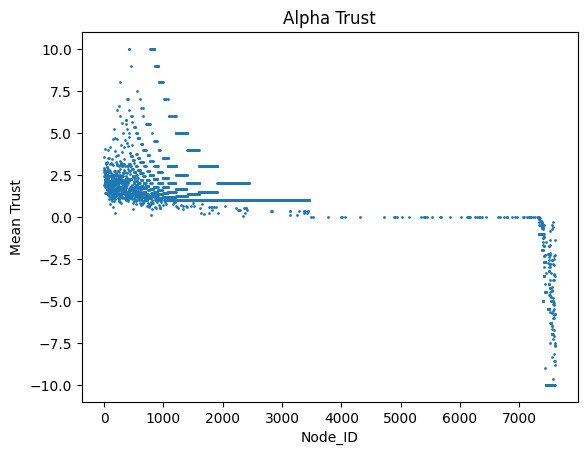

In [166]:
alpha_nodes = Gd_alpha.nodes()
alpha_badness = {}

for node in alpha_nodes():
  number_of_incoming_nodes = Gd_alpha.in_degree(nbunch=node)
  if(number_of_incoming_nodes == 0):
    number_of_incoming_nodes = 1
  incoming_trust = Gd_alpha.in_degree(nbunch=node, weight="trust")
  value = incoming_trust / number_of_incoming_nodes
  alpha_badness[node] = value #badness for every node in alpha

alpha_sorted_dict = dict(sorted(alpha_badness.items()))

plt.title('Alpha Trust')
plt.xlabel('Node_ID')
plt.ylabel('Mean Trust')
plt.plot(alpha_sorted_dict.keys(), alpha_sorted_dict.values(), "o", markersize=1)
plt.show()

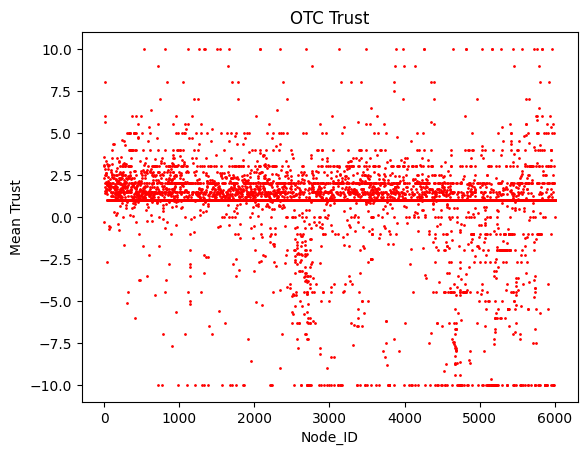

In [167]:
otc_nodes = Gd_otc.nodes()
otc_badness = {}

for node in otc_nodes:
  number_of_incoming_nodes = Gd_otc.in_degree(nbunch=node)
  if(number_of_incoming_nodes == 0):
    number_of_incoming_nodes = 1
  incoming_trust = Gd_otc.in_degree(nbunch=node, weight="trust")
  value = incoming_trust / number_of_incoming_nodes
  otc_badness[node] = value #badness for every node in otc

otc_sorted_dict = dict(sorted(otc_badness.items()))

plt.title('OTC Trust')
plt.xlabel('Node_ID')
plt.ylabel('Mean Trust')
plt.plot(otc_sorted_dict.keys(), otc_sorted_dict.values(), "or", markersize=1)
plt.show()

Compute bad actors using normal distribution

In [168]:
alpha_values = list(alpha_badness.values())
otc_values = list(otc_badness.values())

alpha_mean = np.mean(alpha_values)
otc_mean = np.mean(otc_values)

alpha_std = np.std(alpha_values)
otc_std = np.std(otc_values)

print("Alpha mean: " + str(alpha_mean))
print("Alpha std: " + str(alpha_std))

print("Otc mean: " + str(otc_mean))
print("Otc std: " + str(otc_std))

alpha_bad_nodes = []

for node,value in alpha_badness.items():
  if value < alpha_mean - (3 * alpha_std):
    alpha_bad_nodes.append(node)

otc_bad_nodes = []

for node, value in otc_badness.items():
  if value < otc_mean - (3 * otc_std):
    otc_bad_nodes.append(node)

print("There are: " + str(len(alpha_bad_nodes)) + " bad nodes in alpha")
print("There are: " + str(len(otc_bad_nodes)) + " bad nodes in otc")


Alpha mean: 1.2652376404864218
Alpha std: 2.2366873462767045
Otc mean: 0.7257598347013005
Otc std: 2.8216312840340536
There are: 97 bad nodes in alpha
There are: 212 bad nodes in otc


## Computation of the metrics

Here we compute various metrics for the nodes considered bad actors in the Alpha and OTC networks

### Centralities

Degree Centralities for bad actors

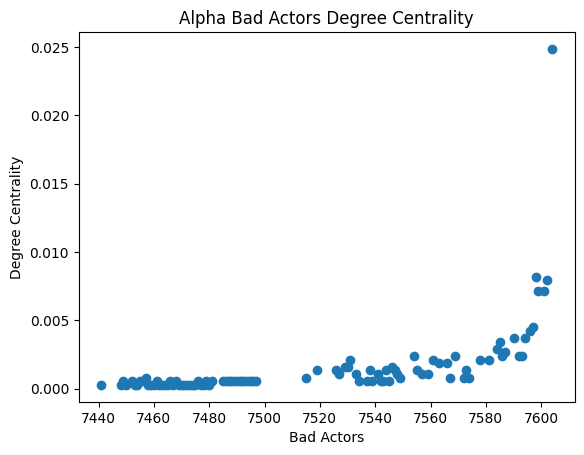

In [170]:
# Degree centralities of nodes in Alpha network
dc_Alpha = nx.degree_centrality(Gd_alpha)
# Degree centralities of bad actors in Alpha network
dc_bad_actors_Alpha = {}
for elem in dc_Alpha.items():
  if elem[0] in alpha_bad_nodes:
    dc_bad_actors_Alpha[elem[0]] = elem[1]

# Plotting of the values
plt.title("Alpha Bad Actors Degree Centrality")
plt.xlabel("Bad Actors")
plt.ylabel("Degree Centrality")
plt.plot(dc_bad_actors_Alpha.keys(), dc_bad_actors_Alpha.values(), "o")
plt.show()

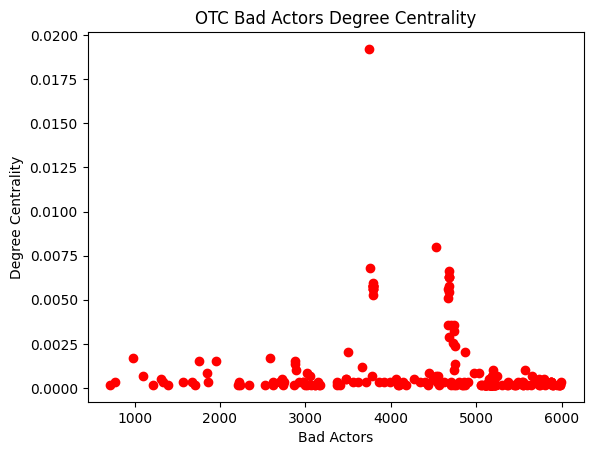

In [171]:
# Degree centralities of nodes in OTC network
dc_OTC = nx.degree_centrality(Gd_otc)
# Degree centralities of bad actors in OTC network
dc_bad_actors_OTC = {}
for elem in dc_OTC.items():
  if elem[0] in otc_bad_nodes:
    dc_bad_actors_OTC[elem[0]] = elem[1]

plt.title("OTC Bad Actors Degree Centrality")
plt.xlabel("Bad Actors")
plt.ylabel("Degree Centrality")
plt.plot(dc_bad_actors_OTC.keys(), dc_bad_actors_OTC.values(), "or")
plt.show()

Closeness Centralities of the bad actors

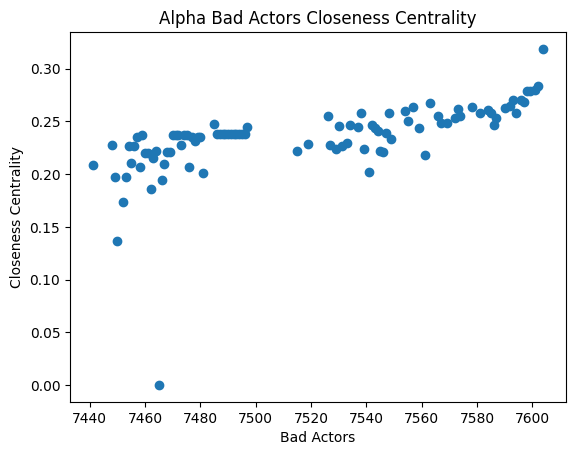

In [172]:
# Closeness centralities of nodes in Alpha network
cc_Alpha = nx.closeness_centrality(Gd_alpha)
# Closeness centralities of bad actors in Alpha network
cc_bad_actors_Alpha = {}
for elem in cc_Alpha.items():
  if elem[0] in alpha_bad_nodes:
    cc_bad_actors_Alpha[elem[0]] = elem[1]

# Plotting of the values
plt.title("Alpha Bad Actors Closeness Centrality")
plt.xlabel("Bad Actors")
plt.ylabel("Closeness Centrality")
plt.plot(cc_bad_actors_Alpha.keys(), cc_bad_actors_Alpha.values(), "o")
plt.show()

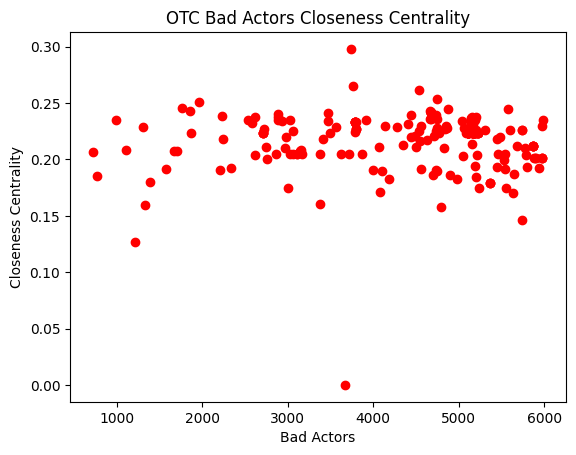

In [173]:
# Closeness centralities of nodes in OTC network
cc_OTC = nx.closeness_centrality(Gd_otc)
# Closeness centralities of bad actors in OTC network
cc_bad_actors_OTC = {}
for elem in cc_OTC.items():
  if elem[0] in otc_bad_nodes:
    cc_bad_actors_OTC[elem[0]] = elem[1]

# Plotting of the values
plt.title("OTC Bad Actors Closeness Centrality")
plt.xlabel("Bad Actors")
plt.ylabel("Closeness Centrality")
plt.plot(cc_bad_actors_OTC.keys(), cc_bad_actors_OTC.values(), "or")

Betweenness Centralities of bad actors

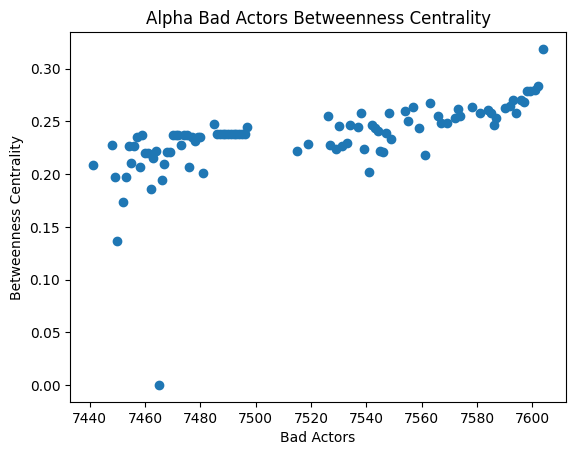

In [174]:
# Betweenness centralities of nodes in Alpha network
bc_Alpha = nx.betweenness_centrality(Gd_alpha)
# Betweenness centralities of bad actors in Alpha network
bc_bad_actors_Alpha = {}
for elem in cc_Alpha.items():
  if elem[0] in alpha_bad_nodes:
    bc_bad_actors_Alpha[elem[0]] = elem[1]

# Plotting of the values
plt.title("Alpha Bad Actors Betweenness Centrality")
plt.xlabel("Bad Actors")
plt.ylabel("Betweenness Centrality")
plt.plot(bc_bad_actors_Alpha.keys(), bc_bad_actors_Alpha.values(), "o")
plt.show()

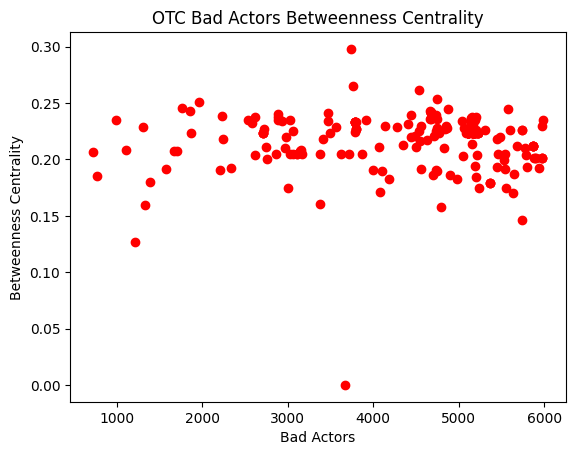

In [175]:
# Betweenness centralities of nodes in OTC network
bc_OTC = nx.betweenness_centrality(Gd_otc)
# Betweenness centralities of bad actors in OTC network
bc_bad_actors_OTC = {}
for elem in cc_OTC.items():
  if elem[0] in otc_bad_nodes:
    bc_bad_actors_OTC[elem[0]] = elem[1]

# Plotting of the values
plt.title("OTC Bad Actors Betweenness Centrality")
plt.xlabel("Bad Actors")
plt.ylabel("Betweenness Centrality")
plt.plot(bc_bad_actors_OTC.keys(), bc_bad_actors_OTC.values(), "or")
plt.show()

### Clustering Coefficients

Compute local clustering coefficient of the bad actors

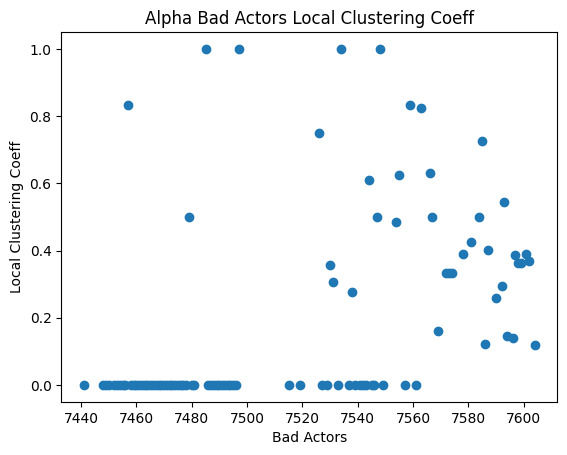

In [176]:
local_cc_alpha = nx.clustering(Gd_alpha)
local_cc_alpha_sorted = dict(sorted(local_cc_alpha.items()))

lcc_bad_actors_Alpha = {}
for elem in local_cc_alpha.items():
  if elem[0] in alpha_bad_nodes:
    lcc_bad_actors_Alpha[elem[0]] = elem[1]

# Plotting of the values
plt.title("Alpha Bad Actors Local Clustering Coeff")
plt.xlabel("Bad Actors")
plt.ylabel("Local Clustering Coeff")
plt.plot(lcc_bad_actors_Alpha.keys(), lcc_bad_actors_Alpha.values(), "o")
plt.show()

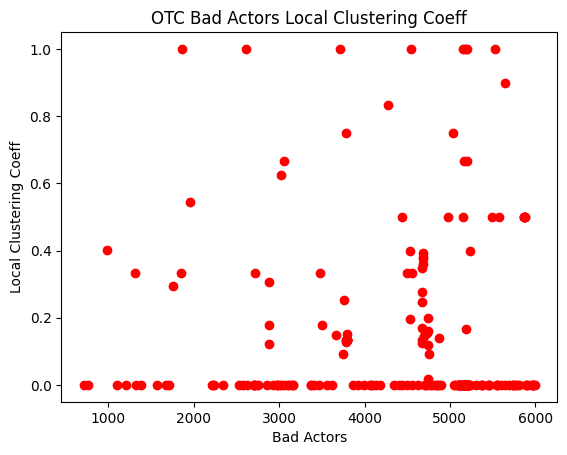

In [177]:
local_cc_otc = nx.clustering(Gd_otc) 

local_cc_otc_sorted = dict(sorted(local_cc_otc.items()))

lcc_bad_actors_OTC = {}
for elem in local_cc_otc.items():
  if elem[0] in otc_bad_nodes:
    lcc_bad_actors_OTC[elem[0]] = elem[1]

# Plotting of the values
plt.title("OTC Bad Actors Local Clustering Coeff")
plt.xlabel("Bad Actors")
plt.ylabel("Local Clustering Coeff")
plt.plot(lcc_bad_actors_OTC.keys(), lcc_bad_actors_OTC.values(), "or")
plt.show()

Compute global clustering coefficient

In [178]:
global_cc_alpha = nx.average_clustering(Gd_alpha)
global_cc_otc = nx.average_clustering(Gd_otc)

print("Global clustering coefficient for alpha network: " + str(global_cc_alpha))
print("Global clustering coefficient for otc network: " + str(global_cc_otc))

Global clustering coefficient for alpha network: 0.15834486458303135
Global clustering coefficient for otc network: 0.15106980550907195


### Motifs' Analysis

Extraction of Motifs from Alpha and OTC networks and comparison of obtained results.
We remove the first 3 triads since we don't have 3 nodes connected in these.
They are not a single connected component, hence, in large networks like Alpha and OTC their amount is out of scale (as done in Superfamilies of Evolved and Designed Networks by Milo el al.).

In [179]:
triadic_census_alpha = nx.triadic_census(Gd_alpha)
# We remove the triads where the 3 nodes aren't connected.
del triadic_census_alpha["003"]
del triadic_census_alpha["012"]
del triadic_census_alpha["102"]

In [180]:
print("3-node motifs for directed graphs (Alpha)")
print("Motif :\tAmount")
for key, value in triadic_census_alpha.items():
    print(f"{key}: {value}")

3-node motifs for directed graphs (Alpha)
Motif :	Amount
021D: 43677
021U: 17083
021C: 27095
111D: 93989
111U: 190593
030T: 974
030C: 64
201: 413062
120D: 1142
120U: 1780
120C: 1163
210: 7136
300: 9894


In [181]:
triadic_census_otc = nx.triadic_census(Gd_otc) 

del triadic_census_otc["003"]
del triadic_census_otc["012"]
del triadic_census_otc["102"]

In [182]:
print("3-node motifs for directed graphs (OTC)")
print("Motif :\tAmount")
for key, value in triadic_census_otc.items():
    print(f"{key}: {value}")

3-node motifs for directed graphs (OTC)
Motif :	Amount
021D: 153801
021U: 36648
021C: 65143
111D: 169731
111U: 440712
030T: 3706
030C: 79
201: 729665
120D: 2048
120U: 2910
120C: 1621
210: 9377
300: 13752


Alpha bad actors ego networks

In [183]:
bad_alpha_ego_graphs = {}
Gd_alpha_reverse = Gd_alpha.reverse()

for bad_node in alpha_bad_nodes:
  out_graph = nx.ego_graph(Gd_alpha, bad_node)
  in_graph = nx.ego_graph(Gd_alpha_reverse, bad_node)

  for u,v in in_graph.edges():
    out_graph.add_edge(v,u) # re-reversing the edges

  bad_alpha_ego_graphs[bad_node] = in_graph

OTC bad actors ego networks

In [184]:
bad_otc_ego_graphs = {}
Gd_otc_reverse = Gd_otc.reverse()

for bad_node in otc_bad_nodes:
  out_graph = nx.ego_graph(Gd_otc, bad_node, radius=2)
  in_graph = nx.ego_graph(Gd_otc_reverse, bad_node, radius=2)

  for u,v in in_graph.edges():
    out_graph.add_edge(v,u) # re-reversing the edges
  
  bad_otc_ego_graphs[bad_node] = in_graph

Plotting of the normalized count of 3-node motifs for the bad actor's ego networks of Alpha

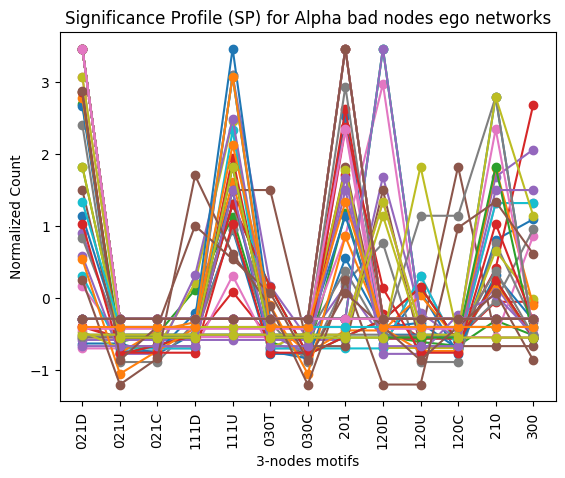

In [185]:
plt.title("Significance Profile (SP) for Alpha bad nodes ego networks")
plt.xlabel("3-nodes motifs")
plt.ylabel("Normalized Count")
plt.xticks(rotation=90)

for node,graph in bad_alpha_ego_graphs.items():
  triadic_census = nx.triadic_census(graph)
  del triadic_census["003"]
  del triadic_census["012"]
  del triadic_census["102"]

  values = np.array(list(triadic_census.values()))
  zscore = stats.zscore(values)

  plt.plot(triadic_census.keys(), zscore, "o", linestyle="-")

plt.show()


Plotting of the normalized count of 3-node motifs for the bad actor's ego networks of Alpha

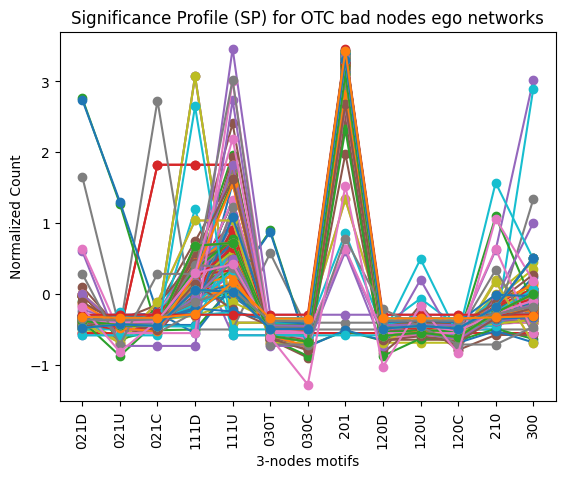

In [186]:
plt.title("Significance Profile (SP) for OTC bad nodes ego networks")
plt.xlabel("3-nodes motifs")
plt.ylabel("Normalized Count")
plt.xticks(rotation=90)

for node,graph in bad_otc_ego_graphs.items():
  triadic_census = nx.triadic_census(graph)
  del triadic_census["003"]
  del triadic_census["012"]
  del triadic_census["102"]

  values = np.array(list(triadic_census.values()))
  zscore = stats.zscore(values)

  plt.plot(triadic_census.keys(), zscore, "o", linestyle="-")

plt.show()

As we can see by analyzing the ego networks of the bad actors, we can notice similar topologic characteristics, given by the massive precence of the motifs "111U" and "201" (present in the ego networks of bad actors of Alpha and OTC).
Also, we can see a "trend" in the amount of other motifs in the ego networks of the same dataset, which indicates that bad actor present a similar topology whithin their network.

# Random Graphs

## Generation

Generating Random Graphs using the Chung-Lu model, on the base of bitcoin-Alpha.

In [187]:
alpha_CL = list()

for i in range(10):
  alpha_CL.append(directed_chung_lu(Gd_alpha))

Generating Random Graphs using the Chung-Lu model, on the base  of bitcoin-OTC.

In [188]:
otc_CL = list()

for i in range(10):
  otc_CL.append(directed_chung_lu(Gd_otc))

Plotting of some of the random graphs created on the base of bitcoin-OTC

## Computation of the metrics

We apply the same metrics used before on the random graphs that we have just generated.


In [189]:
metrics_CL_alpha = []

for graph in alpha_CL:
  metrics_CL_alpha.append(compute_metrics(graph))

In [190]:
metrics_CL_otc = []

for graph in otc_CL:
  metrics_CL_otc.append(compute_metrics(graph))

Extraction of Graphlets and Trees from the random generated graphs.

In [191]:
triadic_census_alpha_CL = []

for graph in alpha_CL:
  triadic_census = nx.triadic_census(graph)
  # removing triplets where the 3 nodes are not connected
  del triadic_census["003"]
  del triadic_census["012"]
  del triadic_census["102"]
  triadic_census_alpha_CL.append(triadic_census)

In [192]:
triadic_census_otc_CL = []

for graph in otc_CL:
  triadic_census = nx.triadic_census(graph)
  # removing triplets where the 3 nodes are not connected
  del triadic_census["003"]
  del triadic_census["012"]
  del triadic_census["102"]
  triadic_census_otc_CL.append(triadic_census)

# Comparison between Alpha and OTC datasets

Firstly, we want to compare the degree centralities, closeness centralities, betweenness centralities, local clustering coefficient and average clustering coefficient between the Alpha and OTC datasets

We use the Monte-Carlo approach to to compute z-score and p-value to do confrontations between features (centrality, betweenness centrality, etc)

1st: z-score, p-value and z-test for the degree centralities of the bad actors of the Alpha dataset

Average Clustering Coefficient:
Alpha: 0.15834486458303135
OTC: 0.15106980550907195


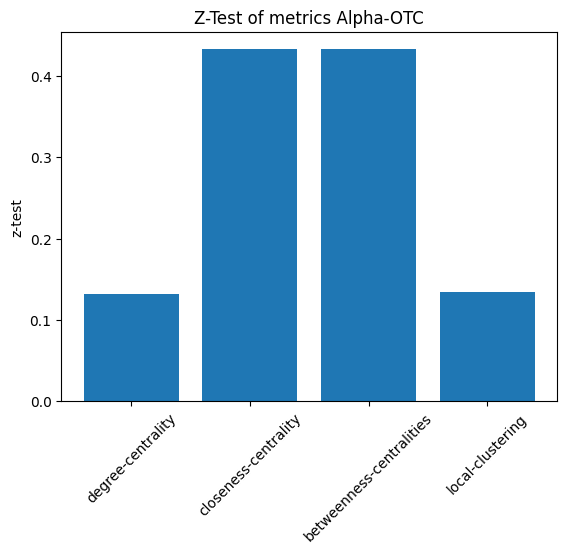

In [193]:
# We use z-test to compare the two distributions of the metrics of the bad nodes of Alpha and OTC
dc_ztest_AlphaOTC = z_test(dc_bad_actors_Alpha, dc_bad_actors_OTC)
cc_ztest_AlphaOTC = z_test(cc_bad_actors_Alpha, cc_bad_actors_OTC)
bc_ztest_AlphaOTC = z_test(bc_bad_actors_Alpha, bc_bad_actors_OTC)
lcc_ztest_AlphaOTC = z_test(lcc_bad_actors_Alpha, lcc_bad_actors_OTC)

metrics_labels = ["degree-centrality", "closeness-centrality", "betweenness-centralities", "local-clustering"]
metrics_values = [dc_ztest_AlphaOTC, cc_ztest_AlphaOTC, bc_ztest_AlphaOTC, lcc_ztest_AlphaOTC]

plt.title("Z-Test of metrics Alpha-OTC")
plt.ylabel("z-test")
plt.xticks(rotation=45)
plt.bar(metrics_labels, metrics_values)

print("Average Clustering Coefficient:")
print("Alpha:", global_cc_alpha)
print("OTC:", global_cc_otc)

We can see that the value of the z-test for every metric is <2, hence we can conclude that the samples from Alpha and OTC dataset are extrimely similar (as expected).

# Comparison with random graphs

For the comparison with random graphs, we compute the z-score and p-values of the metrics of the bad actors of Alpha and OTC datasets, with respect to the various random graphs that we computed.

In [194]:
# We extract all the metrics of the random graphs and we put the in an array
rand_graphs_deg_centralities_Alpha = []
rand_graphs_close_centralities_Alpha = []
rand_graphs_betw_centralities_Alpha = []
rand_graphs_local_clustering_Alpha = []

for graph_metric in metrics_CL_alpha:
    for item in np.array(list(graph_metric["deg_centrality"].values())):
        rand_graphs_deg_centralities_Alpha.append(item)
    for item in np.array(list(graph_metric["close_centrality"].values())):
        rand_graphs_close_centralities_Alpha.append(item)
    for item in np.array(list(graph_metric["betw_centrality"].values())):
        rand_graphs_betw_centralities_Alpha.append(item)
    for item in np.array(list(graph_metric["local_clust"].values())):
        rand_graphs_local_clustering_Alpha.append(item)

In [195]:
# We extract all the metrics of the random graphs and we put the in an array
rand_graphs_deg_centralities_OTC = []
rand_graphs_close_centralities_OTC = []
rand_graphs_betw_centralities_OTC = []
rand_graphs_local_clustering_OTC = []

for graph_metric in metrics_CL_otc:
    for item in np.array(list(graph_metric["deg_centrality"].values())):
        rand_graphs_deg_centralities_OTC.append(item)
    for item in np.array(list(graph_metric["close_centrality"].values())):
        rand_graphs_close_centralities_OTC.append(item)
    for item in np.array(list(graph_metric["betw_centrality"].values())):
        rand_graphs_betw_centralities_OTC.append(item)
    for item in np.array(list(graph_metric["local_clust"].values())):
        rand_graphs_local_clustering_OTC.append(item)

1st: z-score and p-value for degree centralities for Alpha

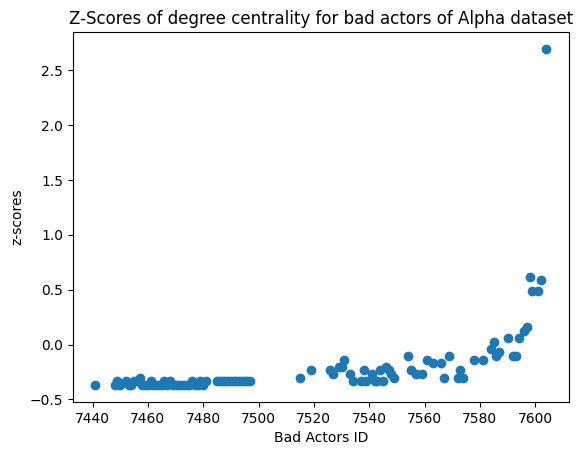

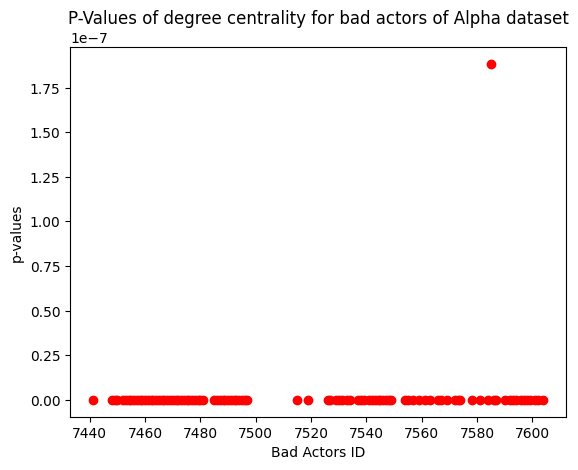

In [196]:
# Computation of the zscores
dc_zscores_Alpha = compute_zscore_set(dc_bad_actors_Alpha, rand_graphs_deg_centralities_Alpha)

# Plotting
plt.title("Z-Scores of degree centrality for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(dc_zscores_Alpha.keys(), dc_zscores_Alpha.values(), 'o')
plt.show()

# Computation of the zscores
dc_pvalues_Alpha = compute_pvalue_set(dc_bad_actors_Alpha, rand_graphs_deg_centralities_Alpha)

# Plotting
plt.title("P-Values of degree centrality for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(dc_pvalues_Alpha.keys(), dc_pvalues_Alpha.values(), 'or')
plt.show()

2nd: z-score and p-value for closeness centralities for Alpha

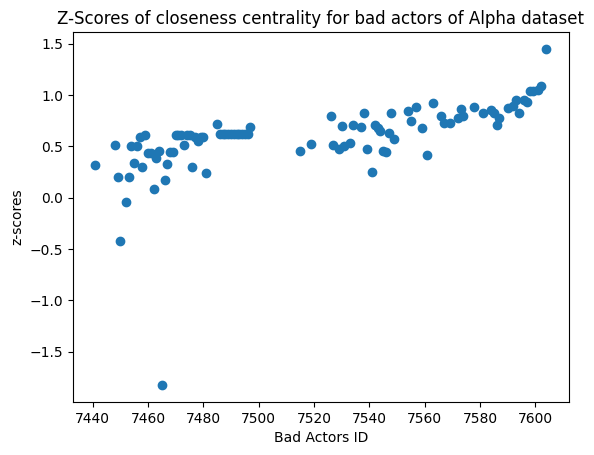

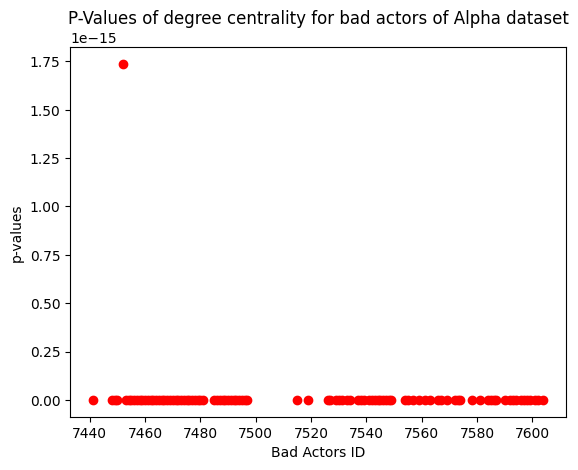

In [197]:
# Computation of the zscores
cc_zscores_Alpha = compute_zscore_set(cc_bad_actors_Alpha, rand_graphs_close_centralities_Alpha)

# Plotting
plt.title("Z-Scores of closeness centrality for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(cc_zscores_Alpha.keys(), cc_zscores_Alpha.values(), 'o')
plt.show()

# Computation of the zscores
cc_pvalues_Alpha = compute_pvalue_set(cc_bad_actors_Alpha, rand_graphs_close_centralities_Alpha)

# Plotting
plt.title("P-Values of degree centrality for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(cc_pvalues_Alpha.keys(), cc_pvalues_Alpha.values(), 'or')
plt.show()

3rd: z-score and p-value for betweenness centralities for Alpha

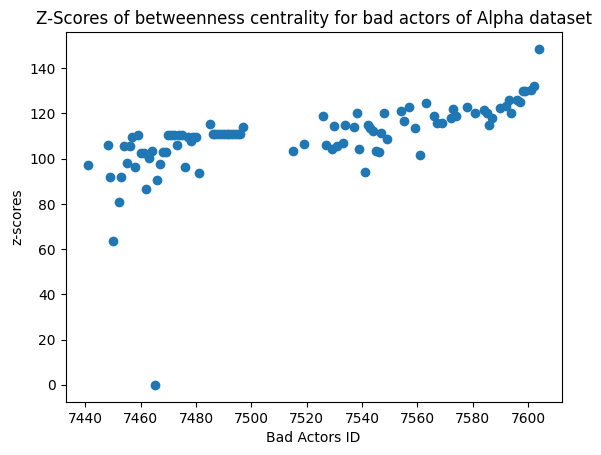

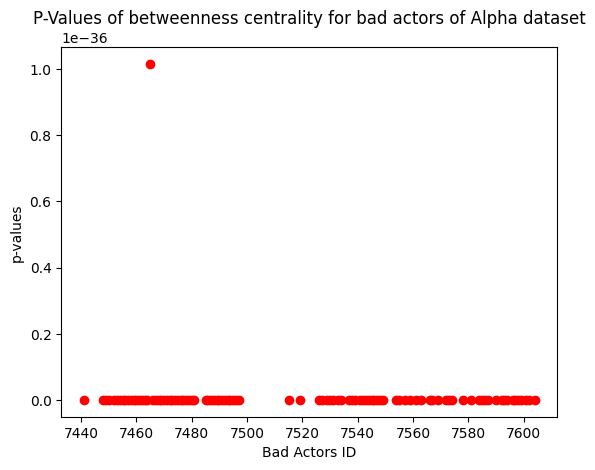

In [198]:
# Computation of the zscores
bc_zscores_Alpha = compute_zscore_set(bc_bad_actors_Alpha, rand_graphs_betw_centralities_Alpha)

# Plotting
plt.title("Z-Scores of betweenness centrality for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(bc_zscores_Alpha.keys(), bc_zscores_Alpha.values(), 'o')
plt.show()

# Computation of the zscores
bc_pvalues_Alpha = compute_pvalue_set(bc_bad_actors_Alpha, rand_graphs_betw_centralities_Alpha)

# Plotting
plt.title("P-Values of betweenness centrality for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(bc_pvalues_Alpha.keys(), bc_pvalues_Alpha.values(), 'or')
plt.show()

4th: z-score and p-value for local clustering coefficient for Alpha

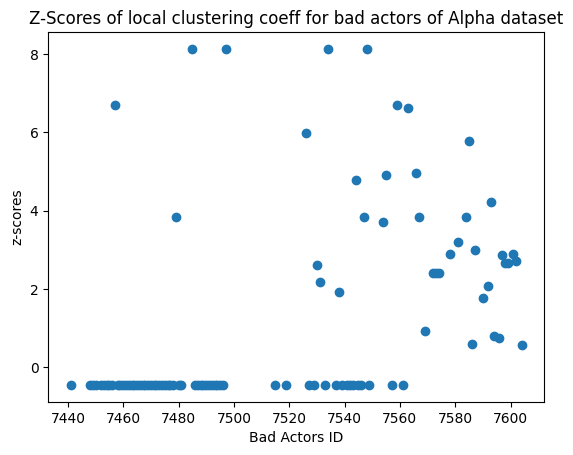

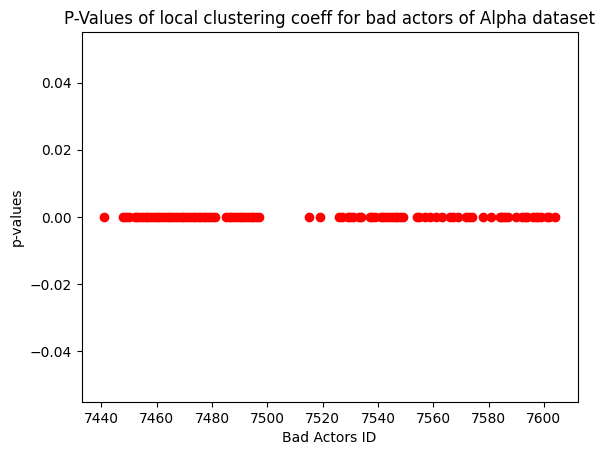

In [199]:
# Computation of the zscores
lcc_zscores_Alpha = compute_zscore_set(lcc_bad_actors_Alpha, rand_graphs_local_clustering_Alpha)

# Plotting
plt.title("Z-Scores of local clustering coeff for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(lcc_zscores_Alpha.keys(), lcc_zscores_Alpha.values(), 'o')
plt.show()

# Computation of the zscores
lcc_pvalues_Alpha = compute_pvalue_set(lcc_bad_actors_Alpha, rand_graphs_local_clustering_Alpha)

# Plotting
plt.title("P-Values of local clustering coeff for bad actors of Alpha dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(lcc_pvalues_Alpha.keys(), lcc_pvalues_Alpha.values(), 'or')
plt.show()

5th: Average Clustering for Alpha

In [200]:
random_avg_clustering_Alpha = []
for graph_metric in metrics_CL_alpha:
    random_avg_clustering_Alpha.append(graph_metric["avg_clust"])

avg_clust_mean_Alpha = np.mean(random_avg_clustering_Alpha)
avg_clust_std_Alpha = np.std(random_avg_clustering_Alpha)

zscore_avg_clust_Alpha = single_zscore(global_cc_alpha, avg_clust_mean_Alpha, avg_clust_std_Alpha)

pvalue_avg_clust_Alpha = single_pvalue(global_cc_alpha, random_avg_clustering_Alpha)

print("Avg clustering Alpha Zscore:", zscore_avg_clust_Alpha)
print("Avg clustering Alpha Pvalue:", pvalue_avg_clust_Alpha)

Avg clustering Alpha Zscore: 50.22659485466063
Avg clustering Alpha Pvalue: 1.269614248230913e-16


1st: z-score and p-value for degree centralities for OTC

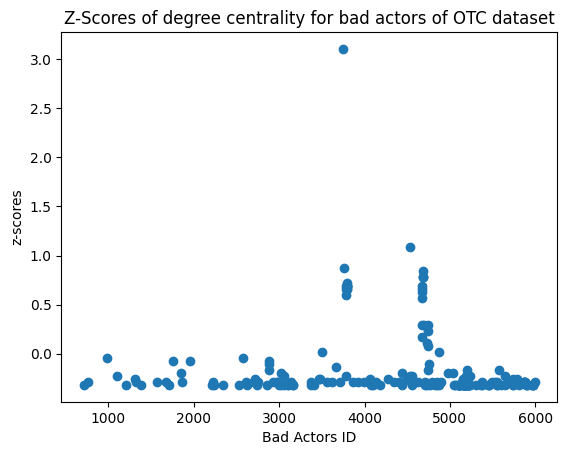

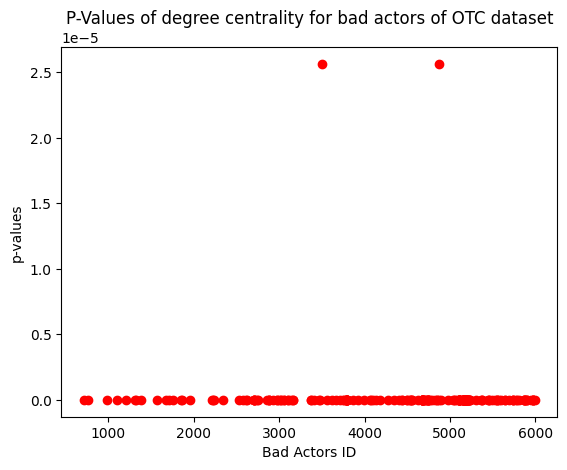

In [201]:
# Computation of the zscores
dc_zscores_OTC = compute_zscore_set(dc_bad_actors_OTC, rand_graphs_deg_centralities_OTC)

# Plotting
plt.title("Z-Scores of degree centrality for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(dc_zscores_OTC.keys(), dc_zscores_OTC.values(), 'o')
plt.show()

# Computation of the zscores
dc_pvalues_OTC = compute_pvalue_set(dc_bad_actors_OTC, rand_graphs_deg_centralities_OTC)

# Plotting
plt.title("P-Values of degree centrality for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(dc_pvalues_OTC.keys(), dc_pvalues_OTC.values(), 'or')
plt.show()

2nd: z-score and p-value for closeness centralities for OTC

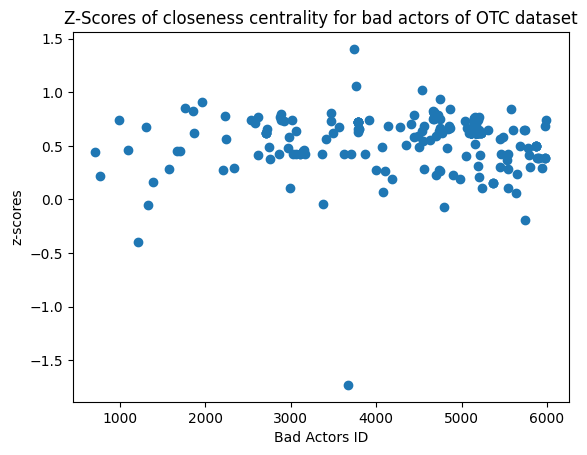

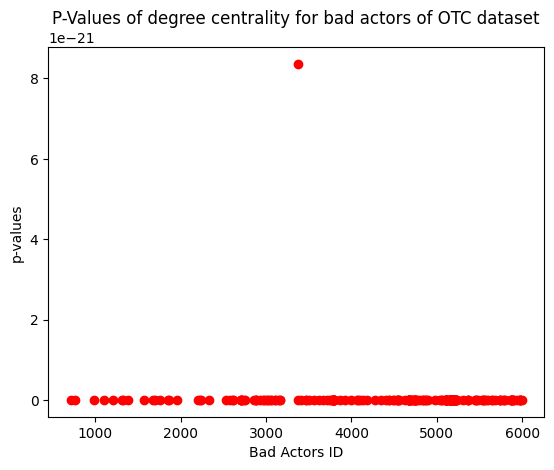

In [202]:
# Computation of the zscores
cc_zscores_OTC = compute_zscore_set(cc_bad_actors_OTC, rand_graphs_close_centralities_OTC)

# Plotting
plt.title("Z-Scores of closeness centrality for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(cc_zscores_OTC.keys(), cc_zscores_OTC.values(), 'o')
plt.show()

# Computation of the zscores
cc_pvalues_OTC = compute_pvalue_set(cc_bad_actors_OTC, rand_graphs_close_centralities_OTC)

# Plotting
plt.title("P-Values of degree centrality for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(cc_pvalues_OTC.keys(), cc_pvalues_OTC.values(), 'or')
plt.show()

3rd: z-score and p-value for betweenness centralities for OTC

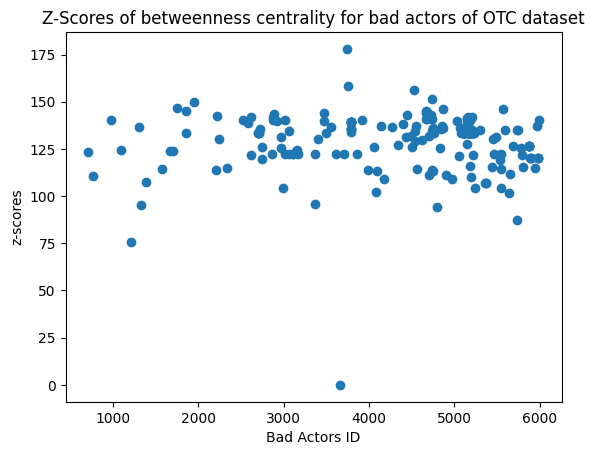

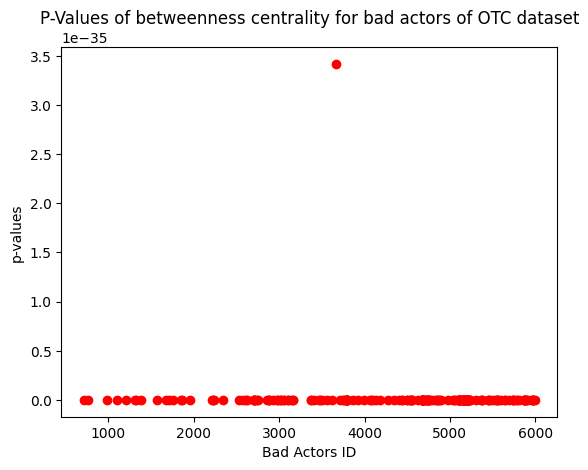

In [203]:
# Computation of the zscores
bc_zscores_OTC = compute_zscore_set(bc_bad_actors_OTC, rand_graphs_betw_centralities_OTC)

# Plotting
plt.title("Z-Scores of betweenness centrality for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(bc_zscores_OTC.keys(), bc_zscores_OTC.values(), 'o')
plt.show()

# Computation of the zscores
bc_pvalues_OTC = compute_pvalue_set(bc_bad_actors_OTC, rand_graphs_betw_centralities_OTC)

# Plotting
plt.title("P-Values of betweenness centrality for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(bc_pvalues_OTC.keys(), bc_pvalues_OTC.values(), 'or')
plt.show()

4th: z-score and p-value for local clustering coefficient for OTC

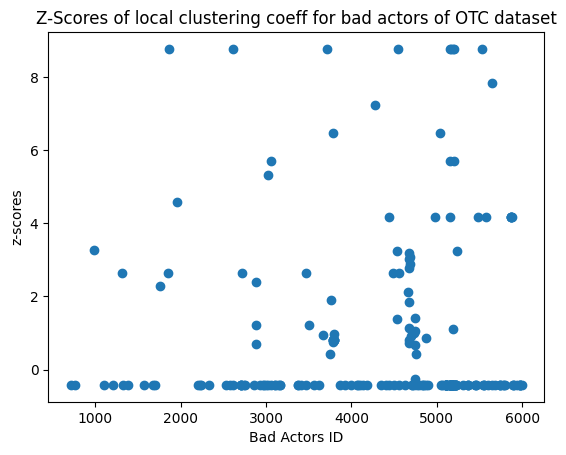

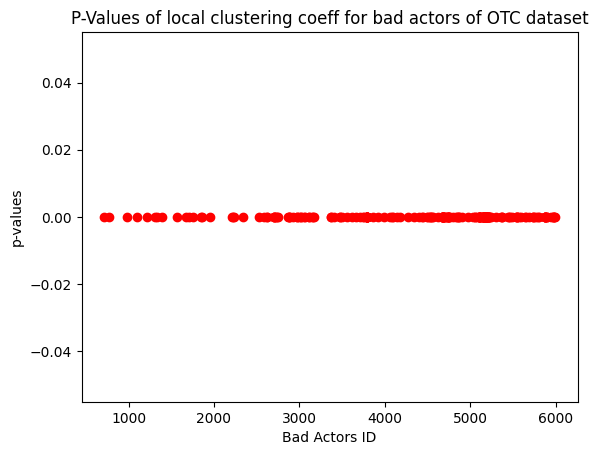

In [204]:
# Computation of the zscores
lcc_zscores_OTC = compute_zscore_set(lcc_bad_actors_OTC, rand_graphs_local_clustering_OTC)

# Plotting
plt.title("Z-Scores of local clustering coeff for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("z-scores")
plt.plot(lcc_zscores_OTC.keys(), lcc_zscores_OTC.values(), 'o')
plt.show()

# Computation of the zscores
lcc_pvalues_OTC = compute_pvalue_set(lcc_bad_actors_OTC, rand_graphs_local_clustering_OTC)

# Plotting
plt.title("P-Values of local clustering coeff for bad actors of OTC dataset")
plt.xlabel("Bad Actors ID")
plt.ylabel("p-values")
plt.plot(lcc_pvalues_OTC.keys(), lcc_pvalues_OTC.values(), 'or')
plt.show()

5th: Average Clustering for OTC

In [205]:
random_avg_clustering_OTC = []
for graph_metric in metrics_CL_otc:
    random_avg_clustering_OTC.append(graph_metric["avg_clust"])

avg_clust_mean_OTC = np.mean(random_avg_clustering_OTC)
avg_clust_std_OTC = np.std(random_avg_clustering_OTC)

zscore_avg_clust_OTC = single_zscore(global_cc_otc, avg_clust_mean_OTC, avg_clust_std_OTC)

pvalue_avg_clust_OTC = single_pvalue(global_cc_otc, random_avg_clustering_OTC)

print("Avg clustering OTC Zscore:", zscore_avg_clust_OTC)
print("Avg clustering OTC Pvalue:", pvalue_avg_clust_OTC)

Avg clustering OTC Zscore: 75.11430350044462
Avg clustering OTC Pvalue: 3.3959467761003267e-18


Computation of the z-score for the comparison of Alpha and the random networks' triads

In [206]:
motif_1_value = []
motif_2_value = []
motif_3_value = []
motif_4_value = []
motif_5_value = []
motif_6_value = []
motif_7_value = []
motif_8_value = []
motif_9_value = []
motif_10_value = []
motif_11_value = []
motif_12_value = []
motif_13_value = []

for triadic_census in triadic_census_alpha_CL:
  for motif, amount in triadic_census.items():
    if motif == "021D": motif_1_value.append(amount)
    elif motif == "021U": motif_2_value.append(amount)
    elif motif == "021C": motif_3_value.append(amount)
    elif motif == "111D": motif_4_value.append(amount)
    elif motif == "111U": motif_5_value.append(amount)
    elif motif == "030T": motif_6_value.append(amount)
    elif motif == "030C": motif_7_value.append(amount)
    elif motif == "201": motif_8_value.append(amount)
    elif motif == "120D": motif_9_value.append(amount)
    elif motif == "120U": motif_10_value.append(amount)
    elif motif == "120C": motif_11_value.append(amount)
    elif motif == "210": motif_12_value.append(amount)
    else: motif_13_value.append(amount)

In [207]:
final_triadic_census_random_alpha = {"021D": [0,0], "021U": [0,0],"021C": [0,0],"111D": [0,0],"111U": [0,0],"030T": [0,0],"030C": [0,0],"201": [0,0],"120D": [0,0],"120U": [0,0],"120C": [0,0],"210": [0,0],"300": [0,0]}

final_triadic_census_random_alpha["021D"][0] = np.mean(np.array(motif_1_value))
final_triadic_census_random_alpha["021U"][0] = np.mean(np.array(motif_2_value))
final_triadic_census_random_alpha["021C"][0] = np.mean(np.array(motif_3_value))
final_triadic_census_random_alpha["111D"][0] = np.mean(np.array(motif_4_value))
final_triadic_census_random_alpha["111U"][0] = np.mean(np.array(motif_5_value))
final_triadic_census_random_alpha["030T"][0] = np.mean(np.array(motif_6_value))
final_triadic_census_random_alpha["030C"][0] = np.mean(np.array(motif_7_value))
final_triadic_census_random_alpha["201"][0] = np.mean(np.array(motif_8_value))
final_triadic_census_random_alpha["120D"][0] = np.mean(np.array(motif_9_value))
final_triadic_census_random_alpha["120U"][0] = np.mean(np.array(motif_10_value))
final_triadic_census_random_alpha["120C"][0] = np.mean(np.array(motif_11_value))
final_triadic_census_random_alpha["210"][0] = np.mean(np.array(motif_12_value))
final_triadic_census_random_alpha["300"][0] = np.mean(np.array(motif_13_value))

final_triadic_census_random_alpha["021D"][1] = np.std(np.array(motif_1_value))
final_triadic_census_random_alpha["021U"][1] = np.std(np.array(motif_2_value))
final_triadic_census_random_alpha["021C"][1] = np.std(np.array(motif_3_value))
final_triadic_census_random_alpha["111D"][1] = np.std(np.array(motif_4_value))
final_triadic_census_random_alpha["111U"][1] = np.std(np.array(motif_5_value))
final_triadic_census_random_alpha["030T"][1] = np.std(np.array(motif_6_value))
final_triadic_census_random_alpha["030C"][1] = np.std(np.array(motif_7_value))
final_triadic_census_random_alpha["201"][1] = np.std(np.array(motif_8_value))
final_triadic_census_random_alpha["120D"][1] = np.std(np.array(motif_9_value))
final_triadic_census_random_alpha["120U"][1] = np.std(np.array(motif_10_value))
final_triadic_census_random_alpha["120C"][1] = np.std(np.array(motif_11_value))
final_triadic_census_random_alpha["210"][1] = np.std(np.array(motif_12_value))
final_triadic_census_random_alpha["300"][1] = np.std(np.array(motif_13_value))

print(final_triadic_census_random_alpha)

{'021D': [120041.1, 4044.1223633812074], '021U': [120448.4, 3067.145650274861], '021C': [240435.2, 4408.854676670575], '111D': [229103.1, 7469.0206513304], '111U': [228422.5, 7770.826780336826], '030T': [7378.9, 266.3063837011798], '030C': [2455.8, 96.76135592270295], '201': [108688.0, 5592.844106534706], '120D': [3488.1, 144.900276052187], '120U': [3472.5, 141.75418865063565], '120C': [6915.6, 317.0943708109622], '210': [6487.6, 435.90072264220896], '300': [1011.6, 114.65007631920705]}


In [208]:
z_score_alpha = []

for motif, amount in triadic_census_alpha.items():
  z_score_alpha.append((triadic_census_alpha[motif] - final_triadic_census_random_alpha[motif][0]) / final_triadic_census_random_alpha[motif][1])

z_score_normalized_alpha = stats.zscore(z_score_alpha)

Computation of the z-score for the comparison of OTC and the random networks' triads

In [209]:
motif_1_value = []
motif_2_value = []
motif_3_value = []
motif_4_value = []
motif_5_value = []
motif_6_value = []
motif_7_value = []
motif_8_value = []
motif_9_value = []
motif_10_value = []
motif_11_value = []
motif_12_value = []
motif_13_value = []

for triadic_census in triadic_census_otc_CL:
  for motif, amount in triadic_census.items():
    if motif == "021D": motif_1_value.append(amount)
    elif motif == "021U": motif_2_value.append(amount)
    elif motif == "021C": motif_3_value.append(amount)
    elif motif == "111D": motif_4_value.append(amount)
    elif motif == "111U": motif_5_value.append(amount)
    elif motif == "030T": motif_6_value.append(amount)
    elif motif == "030C": motif_7_value.append(amount)
    elif motif == "201": motif_8_value.append(amount)
    elif motif == "120D": motif_9_value.append(amount)
    elif motif == "120U": motif_10_value.append(amount)
    elif motif == "120C": motif_11_value.append(amount)
    elif motif == "210": motif_12_value.append(amount)
    else: motif_13_value.append(amount)

In [210]:
final_triadic_census_random_otc = {"021D": [0,0], "021U": [0,0],"021C": [0,0],"111D": [0,0],"111U": [0,0],"030T": [0,0],"030C": [0,0],"201": [0,0],"120D": [0,0],"120U": [0,0],"120C": [0,0],"210": [0,0],"300": [0,0]}

final_triadic_census_random_otc["021D"][0] = np.mean(np.array(motif_1_value))
final_triadic_census_random_otc["021U"][0] = np.mean(np.array(motif_2_value))
final_triadic_census_random_otc["021C"][0] = np.mean(np.array(motif_3_value))
final_triadic_census_random_otc["111D"][0] = np.mean(np.array(motif_4_value))
final_triadic_census_random_otc["111U"][0] = np.mean(np.array(motif_5_value))
final_triadic_census_random_otc["030T"][0] = np.mean(np.array(motif_6_value))
final_triadic_census_random_otc["030C"][0] = np.mean(np.array(motif_7_value))
final_triadic_census_random_otc["201"][0] = np.mean(np.array(motif_8_value))
final_triadic_census_random_otc["120D"][0] = np.mean(np.array(motif_9_value))
final_triadic_census_random_otc["120U"][0] = np.mean(np.array(motif_10_value))
final_triadic_census_random_otc["120C"][0] = np.mean(np.array(motif_11_value))
final_triadic_census_random_otc["210"][0] = np.mean(np.array(motif_12_value))
final_triadic_census_random_otc["300"][0] = np.mean(np.array(motif_13_value))

final_triadic_census_random_otc["021D"][1] = np.std(np.array(motif_1_value))
final_triadic_census_random_otc["021U"][1] = np.std(np.array(motif_2_value))
final_triadic_census_random_otc["021C"][1] = np.std(np.array(motif_3_value))
final_triadic_census_random_otc["111D"][1] = np.std(np.array(motif_4_value))
final_triadic_census_random_otc["111U"][1] = np.std(np.array(motif_5_value))
final_triadic_census_random_otc["030T"][1] = np.std(np.array(motif_6_value))
final_triadic_census_random_otc["030C"][1] = np.std(np.array(motif_7_value))
final_triadic_census_random_otc["201"][1] = np.std(np.array(motif_8_value))
final_triadic_census_random_otc["120D"][1] = np.std(np.array(motif_9_value))
final_triadic_census_random_otc["120U"][1] = np.std(np.array(motif_10_value))
final_triadic_census_random_otc["120C"][1] = np.std(np.array(motif_11_value))
final_triadic_census_random_otc["210"][1] = np.std(np.array(motif_12_value))
final_triadic_census_random_otc["300"][1] = np.std(np.array(motif_13_value))

print(final_triadic_census_random_otc)

{'021D': [212711.4, 4781.579429435425], '021U': [214860.0, 2785.5048016472706], '021C': [428026.1, 5338.092776451154], '111D': [407072.9, 6243.016185306586], '111U': [404980.2, 9231.155765124971], '030T': [10184.4, 328.55294854863195], '030C': [3390.2, 121.1641861277498], '201': [192421.4, 5670.9409660126075], '120D': [4898.2, 128.96185482537075], '120U': [4920.4, 155.2785883501006], '120C': [9723.9, 258.9762344308836], '210': [9336.8, 330.28466509966825], '300': [1456.5, 94.80532685456024]}


In [211]:
z_score_otc = []

for motif, amount in triadic_census_otc.items():
  z_score_otc.append((triadic_census_otc[motif] - final_triadic_census_random_otc[motif][0]) / final_triadic_census_random_alpha[motif][1])

z_score_normalized_otc = stats.zscore(z_score_otc)

Plotting the Significance Profile for both Alpha and OTC

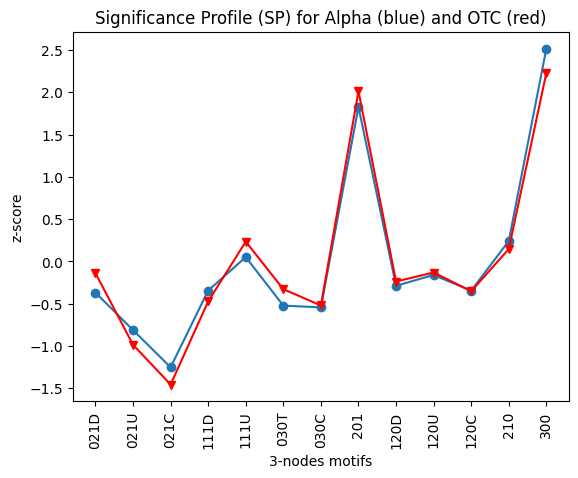

In [212]:
plt.title("Significance Profile (SP) for Alpha (blue) and OTC (red)")
plt.xlabel("3-nodes motifs")
plt.ylabel("z-score")
plt.xticks(rotation=90)
plt.plot(triadic_census_alpha.keys(), z_score_normalized_alpha, "o", linestyle="-")
plt.plot(triadic_census_otc.keys(), z_score_normalized_otc, "vr", linestyle="-")
plt.show()

This confirmes our hypothesis that two different trust networks, Alpha and OTC, are indeed part of the same superfamily of networks.

# Future Develompents

From the work of Longa Antonio, we have come to notice the possibility of analyzing the dynamics of the networks, in terms of searching ego-temporal motifs, which are temporal subgraphs of the network, composed by the neighbourhood of a node in a certain temporal gap.

Below we show how to compute their amount using the library of Longa.
To run below cell clone: https://github.com/AntonioLonga/Egocentric-Temporal-Motifs-Miner-ETMM

In [162]:
# Imports needed to run following code

import construction as cs
from ETN import *
from ETMM import *

Import data for ETN

In [159]:
data_alpha = cs.load_data("soc-sign-bitcoinalpha_notrust.csv")

graphs_alpha = cs.build_graphs(data_alpha, gap=604800) #gap: temporal gap of ~ one month

Counting #ETNs

In [160]:
etn_alpha = count_ETN(graphs_alpha, k=5, meta=None)

etn_alpha = {k: v for k, v in sorted(etn_alpha.items(), key=lambda item: item[1], reverse=1)} 

print("Alpha")
for key,value in etn_alpha.items():
    print(key, value)


Alpha
0b10000 157
0b0000110000 51
0b000010000110000 41
0b101000 24
0b00001000010000110000 23
0b110000 13
0b0000100001000010000110000 12
0b0000100001000010010010000 11
0b00001000010100010000 9
0b0010010000 8
0b000010000100001000010000110000 7
0b000100101000 6
0b000001000001110000 6
0b00001000010010010000 6
0b000010000100001000010100010000 6
0b000010100010000 6
0b100010 5
0b000010101000 5
0b000001000001000001110000 5
0b00001000010000100001000010000100001000010000110000 5
0b0100010000 5
0b000001110000 4
0b00001000010000100001000010010010000 4
0b00001000010000100001000010000110000 4
0b100100 3
0b000010000100101000 3
0b000001100000 3
0b000010000100001000010000100001000010000100001000010000100001000010000100001000010000110000 3
0b000010000100001000010000100001000010000100001000010000100001000010100010000 3
0b0000100001000010000100001000010000110000 3
0b000010000100001000010000100001000010100011000 3
0b0000100001000010000100001000010010010000 3
0b000010010010000 3
0b100000 2
0b000010000010000